# Exercises

In [25]:
# get all files from the notebook here
!git clone https://github.com/irenetiem/neuro_analysis_IT

# import libraries and modules
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os

# changed the path to modules
sys.path.append(os.path.abspath("neuro_analysis_IT/neural-data-master/01-local_field_potential/code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/9nY01qMimFLez40')

fatal: destination path 'neuro_analysis_IT' already exists and is not an empty directory.


## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
# Exercise 1

# import libraries for filtering
from scipy.signal import butter
from scipy.signal import sosfilt

# load data
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

# take 10 seconds of data
lfp = lfp_data['lfp'][0:10000]
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 10.0 seconds of LFP, sampled at 1000.0 Hz


In [19]:
%timeit

# filter the data in different frequency bands
filter_order = np.array([1, 5, 10, 15])
low_f = 5
high_f = 10

filter = np.zeros(len(filter_order))
wideband_lfp = np.zeros(len(lfp))

for i in range(len(filter_order)):
  #define filter object
  filter[i] = butter(filter_order[i], [low_f,high_f], btype='band', output='sos',
                     fs=sampling_rate)

  #apply filter to lfp
  wideband_lfp[i] = sosfilt(filter[i], lfp)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,10,10000),lfp,label='raw signal')

for i in range(len(filter_order)):
  plt.plot(np.linspace(0,10,10000),wideband_lfp[i],label=f'filtered with order {filter_order[i]}')
#plt.plot(np.linspace(0,10,10000),wideband_lfp, label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.legend()
plt.show()

%time

# comment on change in frequency band (not much change, signal get smaller
# in small bands (5-10), time of the simulation does not seem to change
# based on the order or bands (5 - 15 μσ))

ValueError: setting an array element with a sequence.

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram.
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [8]:
# Exercise 2

# import relevant libraries
from pywt import wavelist
from pywt import scale2frequency
from pywt import cwt

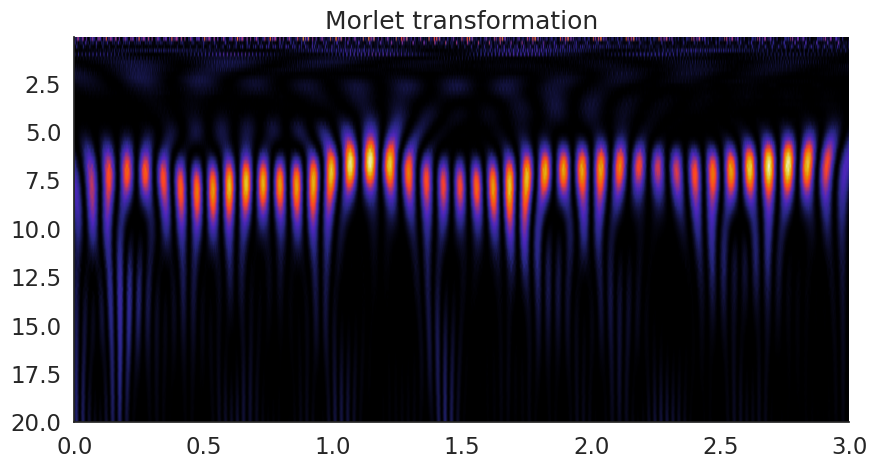

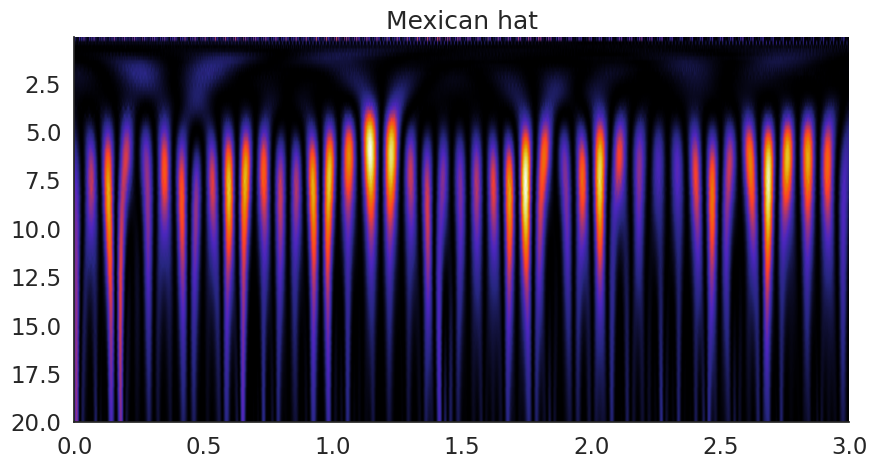

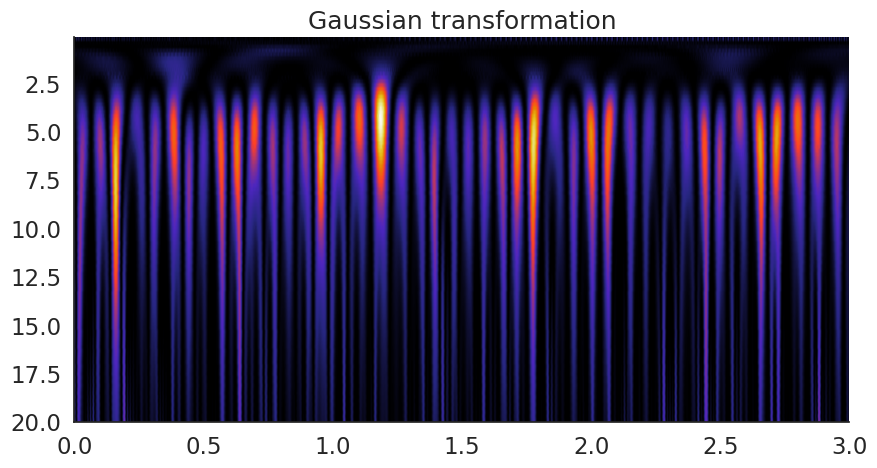

In [16]:
# get data for wavelet (3 seconds)
sig = lfp_data['lfp'][0:3000]
sig = sig - np.mean(sig) # get rid of 0 frequency component

# spectrogram with morlet transform
frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[0, 3,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
plt.title('Morlet transformation')
plt.show()

# spectrogram with mexh transform
frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[0, 3,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
plt.title('Mexican hat')
plt.show()

# spectrogram with gaus transform
frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'gaus1'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[0, 3,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
plt.title('Gaussian transformation')
plt.show()

*Morlet wavelet:* 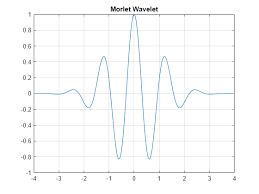

In the first plot with the Morelet wavelet, there is a little spectral leakage. In both the plot with Gaussian and Mexican hat, there is much more.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

Text(0, 0.5, 'power (a.u.)')

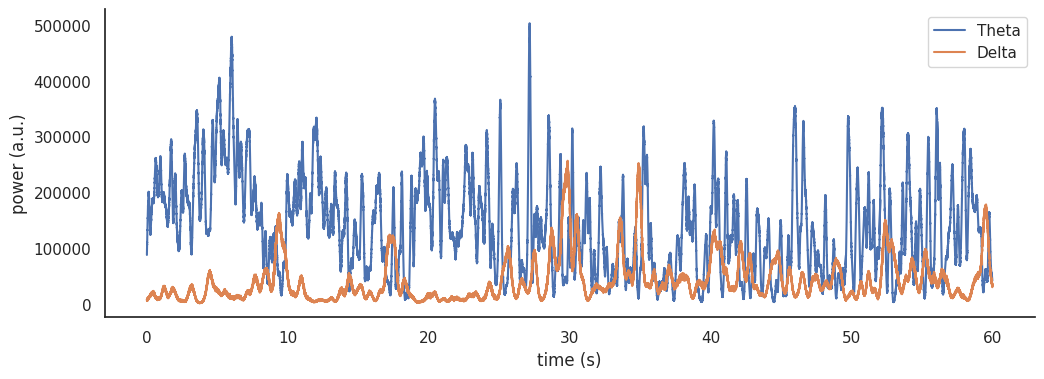

In [83]:
# Exercise 3

# theta bands dominate delta bands during REM

# import data (complete)
lfp = lfp_data['lfp']

# compute instantaneous power
start = 0 #in seconds
end = 60 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

# set frequencies
frequencies_theta =  np.linspace(6,10,50)/sampling_rate
frequencies_delta =  np.linspace(2,4,50)/sampling_rate

wavelet = 'cmor1.0-1.0'

scales_theta = scale2frequency(wavelet, frequencies_theta)
scales_delta = scale2frequency(wavelet, frequencies_delta)

cwtmatr_theta, _ = cwt(sig, wavelet=wavelet, scales=scales_theta,
                  sampling_period=1.0/sampling_rate)
cwtmatr_delta, _ = cwt(sig, wavelet=wavelet, scales=scales_delta,
                  sampling_period=1.0/sampling_rate)

power_theta = np.mean(abs(cwtmatr_theta)**2,axis=0)
power_delta = np.mean(abs(cwtmatr_delta)**2,axis=0)

# plot it
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(start,end,len(power_theta)),power_theta, label = 'Theta')
plt.plot(np.linspace(start,end,len(power_delta)),power_delta, label = 'Delta')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

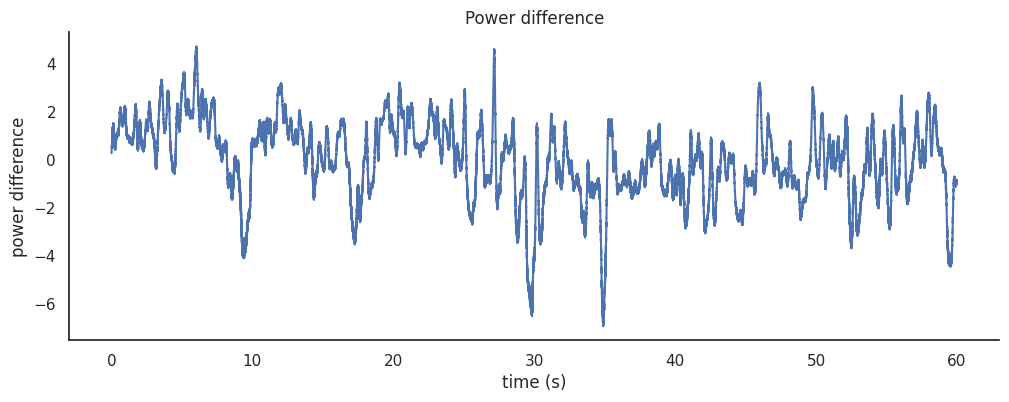

In [84]:
# z-score the signal

# import zscore
from scipy.stats import zscore

# get z-scores
z_theta = zscore(power_theta)
z_delta = (zscore(power_delta))

# compute power differences
power_difference = z_theta - z_delta

# plot it
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(start,end,len(power_difference)),power_difference)
plt.xlabel('time (s)')
plt.ylabel('power difference')
#plt.hlines(y=[0], xmin = 0, xmax = 60, linestyles = ['--'], color = ['gray'])
#plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Power difference')
plt.show()

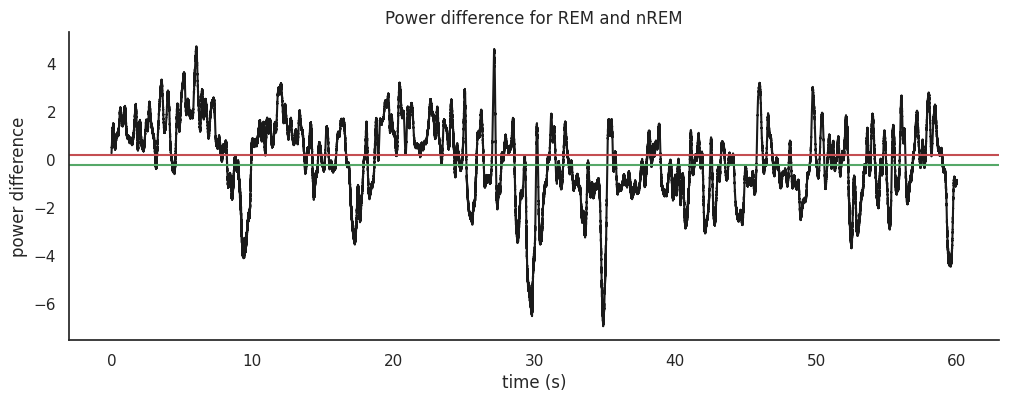

In [95]:
# compute REM and nREM periods
REM = np.zeros(len(power_difference))
nREM = np.zeros(len(power_difference))

for i in range(len(power_difference)):
  if power_difference[i] > 0.2:
    REM[i] = 1
  elif power_difference[i] < -0.2:
    nREM[i] = 1

# plot it
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(start,end,len(power_difference)), power_difference, color='k')
#plt.scatter(np.linspace(start, end, len(power_difference))[REM == 1], power_difference[REM == 1], label='REM')


plt.axhline(y=0.2, color='r', linestyle='-')
plt.axhline(y=-0.2, color='g', linestyle='-')
plt.xlabel('time (s)')
plt.ylabel('power difference')
plt.title('Power difference for REM and nREM')
plt.show()

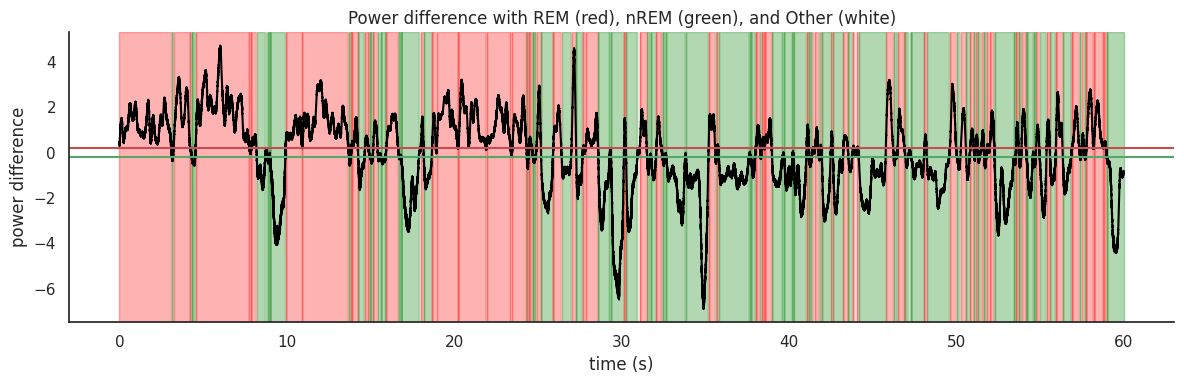

In [94]:
# add color in background to make it clearer where REM and nREM is
# this part is made with AI

# Define sleep states
states = np.full(len(power_difference), 'other', dtype=object)
states[power_difference > 0.2] = 'REM'
states[power_difference < -0.2] = 'nREM'

# Plot setup
plt.figure(figsize=(12, 4))

# Draw background spans
colors = {'REM': 'red', 'nREM': 'green', 'other': 'white'}
current_state = states[0]
start_idx = 0

for i in range(1, len(states)):
    if states[i] != current_state:
        plt.axvspan(time[start_idx], time[i], color=colors[current_state], alpha=0.3)
        current_state = states[i]
        start_idx = i

# Final span
plt.axvspan(time[start_idx], time[-1], color=colors[current_state], alpha=0.3)

# Plot the power difference curve
plt.plot(time, power_difference, color='black')
plt.axhline(0.2, color='r', linestyle='-')
plt.axhline(-0.2, color='g', linestyle='-')
plt.xlabel('time (s)')
plt.ylabel('power difference')
plt.title('Power difference with REM (red), nREM (green), and Other (white)')
plt.tight_layout()
plt.show()

In [78]:
# find periods of 2 seconds for REM and nREM

# REM
# skip first 5 seconds
for i in range(5000, len(REM)):
  cont = False
  for j in range(2000):
    if REM[i+j] == 1:
      cont = True
      break
  if cont == False:
    print(i)
    init_REM = i
    break

# this returns 32393, so after 3 seconds (and a bit), there is a frame
# of two seconds only REM

# now find one for nREM
# skip first 10 seconds
for i in range(10000, len(REM)):
  cont = False
  for j in range(2000):
    if REM[i+j] == 0:
      cont = True
      break
  if cont == False:
    print(i)
    init_nREM = i
    break

# this gives 10921

32393
10921


[]

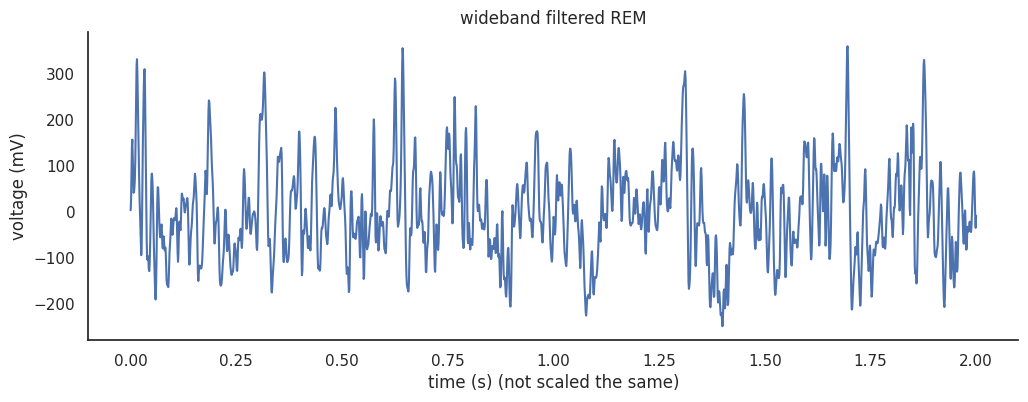

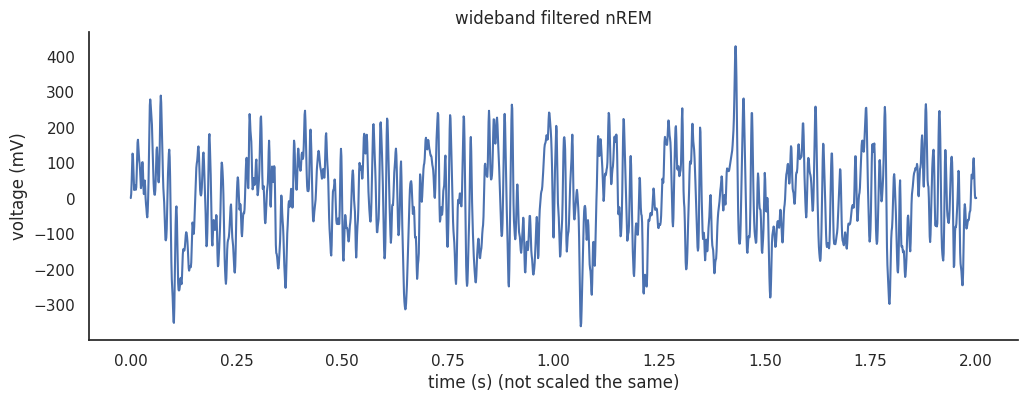

In [81]:
# plot for both wideband signal

# get lfp signal
lfp_REM = lfp_data['lfp'][init_REM:init_REM+2000]
lfp_nREM = lfp_data['lfp'][init_nREM:init_nREM+2000]

# get wideband signal
filter_order = 5 #the higher the order, the sharper the filter frequency response,
                 #but with more computations and potental numerical instability
low_f = 1
high_f = 200

#define filter object
filter = butter(filter_order,[low_f,high_f],
                btype='band',
                output='sos',
                fs=sampling_rate)

#apply filter to lfp
wideband_lfp_REM = sosfilt(filter, lfp_REM)
wideband_lfp_nREM = sosfilt(filter, lfp_nREM)

# plot it
plt.figure(figsize=(12,4))
plt.plot(np.linspace(0,2,2000),wideband_lfp_REM[:2000])
plt.title('wideband filtered REM')
plt.xlabel('time (s) (not the same starttime)')
plt.ylabel('voltage (mV)')
plt.plot()

plt.figure(figsize=(12,4))
plt.plot(np.linspace(0,2,2000),wideband_lfp_nREM[:2000])
plt.title('wideband filtered nREM')
plt.xlabel('time (s) (not the same starttime)')
plt.ylabel('voltage (mV)')
plt.plot()